In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1


In [2]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=["description", "points"])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


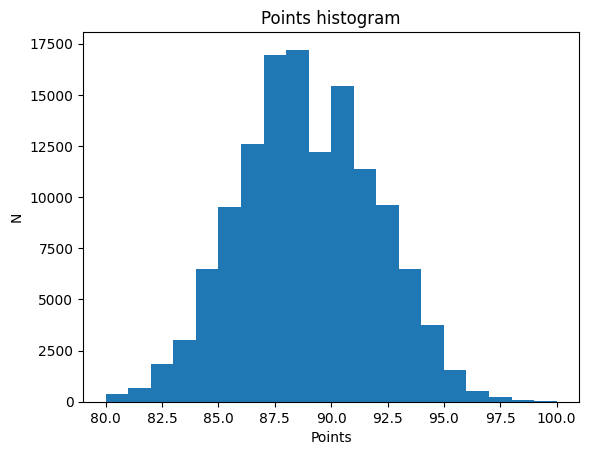

In [6]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [7]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [10]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [11]:
embed = hub.load("https://www.kaggle.com/models/google/nnlm/TensorFlow2/en-dim50/1")
hub_layer = hub.KerasLayer(embed, dtype=tf.string, trainable=True)
hub_layer = tf.keras.layers.Lambda(hub_layer)

In [12]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4247149 , -0.14269368, -0.1511832 , ..., -0.20652665,
        -0.15626381, -0.02357167],
       [ 0.31491607,  0.04735291,  0.15901992, ..., -0.14299555,
        -0.33644533,  0.10242586],
       [ 0.3657893 , -0.1539051 ,  0.09919778, ...,  0.13236831,
        -0.24703051,  0.17948665],
       ...,
       [ 0.4621098 , -0.04461296,  0.02104516, ...,  0.16758516,
        -0.1905935 ,  0.11178785],
       [ 0.6768252 , -0.09687576, -0.11149039, ..., -0.03024951,
         0.01652636,  0.12522222],
       [ 0.5434955 , -0.06524075, -0.03536213, ..., -0.05161628,
        -0.18475924, -0.01460376]], dtype=float32)>

In [13]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [15]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4351 - loss: 0.7017


[0.7018802762031555, 0.43355196714401245]

In [16]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4286 - loss: 0.7024


[0.7020404934883118, 0.43486958742141724]

In [17]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5749 - loss: 0.6825 - val_accuracy: 0.6223 - val_loss: 0.6494
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6266 - loss: 0.6482 - val_accuracy: 0.6495 - val_loss: 0.6188
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6484 - loss: 0.6255 - val_accuracy: 0.6852 - val_loss: 0.5995
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6620 - loss: 0.6135 - val_accuracy: 0.6922 - val_loss: 0.5892
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6735 - loss: 0.6024 - val_accuracy: 0.6960 - val_loss: 0.5839


In [18]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6929 - loss: 0.5810


[0.5818213820457458, 0.6938759684562683]

# LSTM

In [19]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [23]:
model.evaluate(train_data)
model.evaluate(valid_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5891 - loss: 0.6925
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5885 - loss: 0.6924


[0.6924346089363098, 0.5922905206680298]

In [24]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.6559 - loss: 0.6187 - val_accuracy: 0.8300 - val_loss: 0.3747
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.8324 - loss: 0.3734 - val_accuracy: 0.8399 - val_loss: 0.3479
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.8422 - loss: 0.3488 - val_accuracy: 0.8413 - val_loss: 0.3474
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.8472 - loss: 0.3409 - val_accuracy: 0.8417 - val_loss: 0.3439
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.8508 - loss: 0.3321 - val_accuracy: 0.8420 - val_loss: 0.3441


In [25]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8408 - loss: 0.3420


[0.3484238386154175, 0.8391290903091431]